In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
df1 = pd.read_csv('BCHAIN-MKPRU.csv',header=0,index_col=0,parse_dates = True)
df2 = pd.read_csv('LBMA-GOLD.csv',header=0,index_col=0,parse_dates = True)
df2.fillna(df2.mean(),axis=0,inplace=True)
price_A = df1.diff(1).dropna()
price_B = df2.diff(1).dropna()
# 因为不协整所以做了差分。
df = pd.concat([price_A,price_B],axis=1,join='inner')
agold = 0.01
abitcoin = 0.02
# 初始化资产
gold = 0.0
bitcoin = 0.0


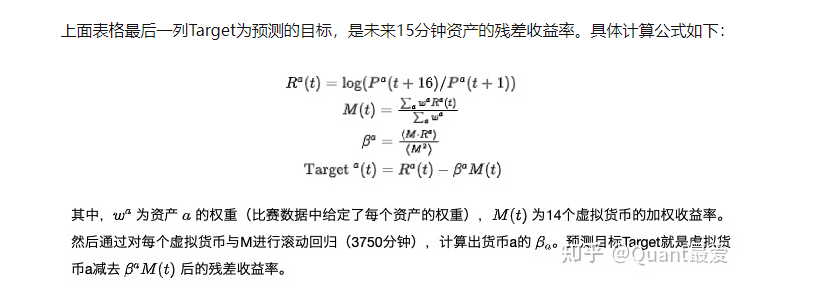

In [29]:
from math import log

In [30]:
def target(df,w,time):
    pw = np.power(df,w)
    rwt = np.log(pw * (time +16)/pw*(time+1)).max()
    M = pd.DataFrame(np.dot(pw,rwt))
    bw = pd.DataFrame(np.dot(M,rwt))/np.dot(M,2)
    return rwt - np.multiply(bw ,M).max()
    

In [31]:
target(df1,0.5,2)

Value   NaN
0       NaN
dtype: float64

[5371.89543254]


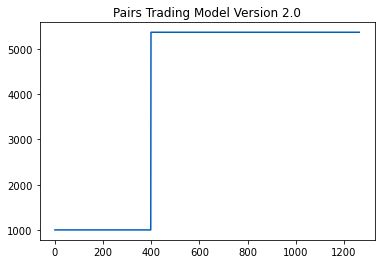

In [108]:
'''框架
# coding=utf-8
from __future__ import print_function, absolute_import, unicode_literals
import numpy as np
init = 1000.0
def on_bar(df1,df2,init,gold,bitcoin,wgold,wbitcoin):
    # 数据提取
    j_close = df1.values
    jm_close =df2.values
    # 提取最新价差
    new_price = j_close[-1] - jm_close[-1]
    # 计算历史价差,上下限，止损点
    spread_history = j_close[:-2] -  jm_close[:-2]
    spread_history_mean = np.mean(spread_history)
    spread_history_std = np.std(spread_history)
    up = spread_history_mean + 0.75 * spread_history_std
    down = spread_history_mean - 0.75 * spread_history_std
    up_stoppoint = spread_history_mean + 2 * spread_history_std
    down_stoppoint = spread_history_mean - 2 * spread_history_std
    # 查持仓
    position_jm_long = 0
    position_jm_short = 1
    # 设计买卖信号
    # 设计开仓信号
    if not position_jm_short and not position_jm_long:
        if new_price > up:
            print('做空价差组合')
            pass
        if new_price < down:
            print('做多价差组合')
            pass
    # 设计平仓信号
    # 持jm多仓时
    if position_jm_long:
        if new_price >=  spread_history_mean:
            # 价差回归到均值水平时，平仓
            print('价差回归到均衡水平，平仓')
            pass
        if new_price < down_stoppoint:
            # 价差达到止损位，平仓止损
            print('价差超过止损点，平仓止损')
            pass
    # 持jm空仓时
    if position_jm_short:
        if new_price <= spread_history_mean:
            # 价差回归到均值水平时，平仓
            print('价差回归到均衡水平，平仓')
            pass
        if new_price > up_stoppoint:
            # 价差达到止损位，平仓止损
            print('价差超过止损点，平仓止损')
            pass 
'''
def strategy():
    price_A = df1.values[:len(df2)]
    price_B = df2.values[:len(df2)]
    spread = price_A - price_B
    mspread = spread - np.mean(spread)
    sigma = np.std(mspread)
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 1000
    agold =0.01
    abitcoin = 0.02
    z_entry_threshold=0.5
    z_exit_threshold1=3
    zscore = mspread/sigma
    for i in range(len(price_A)):
        if hold == False:
            if  zscore[i] >= z_entry_threshold:
                hold_price_A = price_A[i]
                hold_price_B = price_B[i]
                hold_state = -1
                hold = True
            elif zscore[i] <= -z_entry_threshold:
                hold_price_A = price_A[i]
                hold_price_B = price_B[i]
                hold_state = 1
                hold = True
        else:
            if zscore[i] >= z_exit_threshold1 and hold_state == -1 :
                profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                profit_sum += profit
                hold_state = 0
                hold = False
            if zscore[i] <= -z_exit_threshold1 and hold_state == 1 :
                profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B*(1-agold) - price_B[i])
                profit_sum += profit
                hold_state = 0
                hold = False
            if zscore[i] <= 0 and hold_state == -1:
                profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                profit_sum += profit
                hold_state = 0
                hold = False
            if zscore[i] >= 0 and hold_state == 1:
                profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B *(1-agold)- price_B[i])
                profit_sum += profit
                hold_state = 0
                hold = False
        profit_list.append(profit_sum)
    print(profit_list[-1])
 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(profit_list)), profit_list,color ='#005FB8')
    plt.title('Pairs Trading Model Version 2.0')
    # plt.savefig('1.0.png')
    plt.show()
strategy()

In [90]:
from statsmodels.tsa.stattools import coint
def create_pairs_dataframe(df, symbols):
    print("Importing CSV data")   #Open the individual CSV files and read into pandas
    print ("Constructing dual matrix for %s and %s" % symbols)
    pairs = pd.DataFrame(index=df.index)
    pairs['%s_close' % symbols[0]] = df['Value']
    pairs['%s_close' % symbols[1]] = df['USD (PM)']
    pairs = pairs.dropna()
    return pairs
def check_cointegration(pairs, symbols):
    print("Computing Cointegration")
    coin_result=coint(pairs['%s_close' % symbols[0]],pairs['%s_close' % symbols[1]])   #Cointegration calculating
    return coin_result[1]
def calculate_spread_zscore(pairs, symbols):
    pairs['returns']=(pairs['%s_close' % symbols[0]]-pairs['%s_close' %symbols[1]]/pairs['%s_close' %symbols[1]])
    # print(pairs['returns'].describe())
    pairs['mean']=pairs['returns'].rolling(window=1,center=False).mean()
    # print(pairs['mean'])
    pairs = pairs.dropna()
    print ("Creating the spread/zscore columns")
    pairs['zscore'] = (pairs['returns']-pairs['mean'])/pairs['returns'].std()
    # print(pairs['zscore'])
    pairs['returns'].rolling(window=1,center=False).std()
    # print(pairs['returns'])
    return pairs

def signal_generate(pairs, symbols,
                    z_entry_threshold=0.2,   #z_enter_threshold for entering a position
                    z_exit_threshold1=0.5,
                    z_exit_threshold2=1.5):   #z_exit_threshold for exiting a position
    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0   #Long or short decision
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
    pairs['exits'] = ((np.abs(pairs['zscore']) <= z_exit_threshold1 ) )*1.0
    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0
    long_market = 0.0
    short_market = 0.0
    for i, b in enumerate(pairs.iterrows()):
        if pairs['longs'][i-1] == 1.0:   #Compute long positions
            long_market = 1.0
        if pairs['shorts'][i-1] == 1.0:   #Compute short positions
            short_market = 1.0
        # p.abs(pairs['zscore'][i-1])
        if pairs['exits'][i-1] == 1.0 or  ((np.abs(pairs['zscore'][i]-pairs['zscore'][i-1]) > 1) and (np.abs(pairs['zscore'][i]+pairs['zscore'][i-1]) < 1)) :
            pairs['exits'][i-1]=1
            long_market = 0.0
            short_market = 0.0
        pairs['long_market'][i] = long_market
        pairs['short_market'][i] = short_market
    return pairs

def portfolio_returns(pairs, symbols):   #Vectorized treatment
    sym1 = symbols[0]
    sym2 = symbols[1]
    pairs['ret_%s' % symbols[0]]=((pairs['%s_close' %sym1]*1.02-pairs['%s_close' %sym1].shift(1))-1)
    pairs['ret_%s' % symbols[1]]=((pairs['%s_close' %sym2]*1.01-pairs['%s_close' %sym2].shift(1))-1)
    # print "Constructing a portfolio"
    portfolio = pd.DataFrame(index=pairs.index)
    portfolio['positions'] = pairs['long_market'] - pairs['short_market']
    pairs['positions'] = pairs['long_market'] - pairs['short_market']
    pairs[sym1] = pairs['ret_%s' % symbols[0]] 
    pairs[sym2] = -1.0*pairs['ret_%s' % symbols[1]] 
    pairs.fillna(0.0, inplace=True)
    pairs['total'] = pairs[sym1] + pairs[sym2]
    # print(pairs['total'])
    portfolio['total'] = pairs[sym1] + pairs[sym2]
    portfolio['total'].fillna(0.0, inplace=True)
    portfolio['total'].replace([np.inf, -np.inf], 0.0, inplace=True)
    # print "Constructing the equity curve"
    portfolio['returns'] = portfolio['total'].pct_change()   #Density curve calculation
    # print(portfolio['returns'])
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)
    pairs['total'].plot(color='r')
    portfolio['cumu_sum']=portfolio['total'].cumsum()
    portfolio['cumu_sum'].plot(color = 'b')
    pairs['ret_%s' % symbols[0]].plot(color = '#005FB8')
    (pairs['ret_%s' % symbols[1]]).plot(color = '#00A3A3')
    plt.xlabel("Date and time")
    plt.ylabel("Cumulative Returns in %");
    plt.legend(loc = 'lower right')
    plt.grid(False)
    plt.title('Pairs Trading Model Version 2.0')
    plt.savefig('2.0.png')
    return portfolio

Importing CSV data
Constructing dual matrix for BCHAIN-MKPRU and LBMA-GOLD
Computing Cointegration
Creating the spread/zscore columns


C:\Users\TRACYT~1\AppData\Local\Temp/ipykernel_20112/1565021971.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs['zscore'] = (pairs['returns']-pairs['mean'])/pairs['returns'].std()


,BCHAIN-MKPRU_close,LBMA-GOLD_close,returns,mean,zscore,longs,shorts,exits,long_market,short_market,ret_BCHAIN-MKPRU,ret_LBMA-GOLD,positions,BCHAIN-MKPRU,LBMA-GOLD,total
Date,,,,,,,,,,,,,,,,
2016-09-13,1.25,-0.95,0.25,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
2016-09-14,-2.10,-1.90,-3.10,-3.10,0.0,0.0,0.0,1.0,0.0,0.0,-4.3920,-1.9690,0.0,-4.3920,1.9690,-2.4230
2016-09-15,1.56,-10.95,0.56,0.56,0.0,0.0,0.0,1.0,0.0,0.0,2.6912,-10.1595,0.0,2.6912,10.1595,12.8507
2016-09-16,-1.27,-2.45,-2.27,-2.27,0.0,0.0,0.0,1.0,0.0,0.0,-3.8554,7.4755,0.0,-3.8554,-7.4755,-11.3309
2016-09-19,-1.39,6.50,-2.39,-2.39,0.0,0.0,0.0,1.0,0.0,0.0,-1.1478,8.0150,0.0,-1.1478,-8.0150,-9.1628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,1821.68,-2.10,1820.68,1820.68,0.0,0.0,0.0,1.0,0.0,0.0,1390.8636,-14.2710,0.0,1390.8636,14.2710,1405.1346
2021-09-07,908.34,-19.45,907.34,907.34,0.0,0.0,0.0,1.0,0.0,0.0,-896.1732,-18.5445,0.0,-896.1732,18.5445,-877.6287
2021-09-08,-5868.23,-16.15,-5869.23,-5869.23,0.0,0.0,0.0,1.0,0.0,0.0,-6894.9346,2.1385,0.0,-6894.9346,-2.1385,-6897.0731


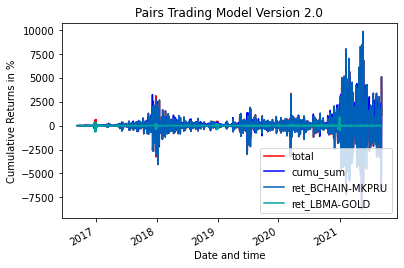

In [91]:
# spread = price_A - price_B
# mspread = spread - np.mean(spread)
# sigma = np.std(mspread)
# open = 2 * sigma
# stop = 3 * sigma
profit_list = []
hold = False
hold_price_A = 0
hold_price_B = 0
hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
profit_sum = 1000
agold = 0.01
abitcoin = 0.02
symbols = ('BCHAIN-MKPRU', 'LBMA-GOLD')
# lot_size= (1200,400)
returns = []
pairs = create_pairs_dataframe(df, symbols)
coint_check = check_cointegration(pairs, symbols)
if coint_check < 0.47:
     # print "Pairs are cointegrated"
     # print coint_check
    pairs = calculate_spread_zscore(pairs, symbols)
    pairs = signal_generate(pairs, symbols,
                             z_entry_threshold=0.2,
                             z_exit_threshold1=0.5,
                             z_exit_threshold2=1.5)   #Create the signal spread and then a z-score of the spread
    portfolio = portfolio_returns(pairs, symbols)
    pairs.to_csv("op.csv")
else:
     # print coint_check
    print("Pairs are not cointegrated. Failed order")
pairs

In [92]:
returns

[]

In [11]:
from statsmodels.tsa.stattools import adfuller
 
def check():
    result_A = adfuller(df1)
    result_B = adfuller(df2)
    print(result_A)
    print(result_B)

In [12]:
check()

(-0.23774252687897687, 0.9338707177253289, 24, 1801, {'1%': -3.4339861159726306, '5%': -2.863146142843122, '10%': -2.5676250581282964}, 29168.935944417746)
(-0.40130142236225275, 0.9098812595566211, 12, 1252, {'1%': -3.4355838322867998, '5%': -2.863851267837805, '10%': -2.5680005460145554}, 11791.035442225255)


- 从结果可以看出 t-statistic 的值要大于10%，所以说无法拒绝原假设，也就是原数据都是非平稳的。

In [13]:
def check():
    price_A = df1.diff(1).dropna()
    price_B = df2.diff(1).dropna()
    result_A = adfuller(price_A)
    result_B = adfuller(price_B)
    print(result_A)
    print(result_B)
check()

(-8.535405377369184, 1.0111831893570238e-13, 23, 1801, {'1%': -3.4339861159726306, '5%': -2.863146142843122, '10%': -2.5676250581282964}, 29151.81649615494)
(-12.091194166941165, 2.120676131115867e-22, 11, 1252, {'1%': -3.4355838322867998, '5%': -2.863851267837805, '10%': -2.5680005460145554}, 11780.62474277005)


- 一节差分后平稳

In [14]:
from statsmodels.tsa.stattools import coint
 
def check():
    price_A = df1.diff(1).dropna()
    price_B = df2.diff(1).dropna()
    price_A = price_A.values[:1200]
    price_B = price_B.values[:1200]
    print(coint(price_A, price_B))
check()

(-6.925060445934731, 1.2926537075485351e-08, array([-3.90559752, -3.34123074, -3.04798917]))


-  t-statistic 小于5%: 有95%的把握说两者具有协整关系。
- 投资组合的构建
配对交易主要分析的对象是两个品种价格之间的偏离，由均值回归理论知，在股票、期货或者其他金融衍生品的交易市场中，无论高于或低于价值中枢（或均值）都有很高的概率向价值中枢回归的趋势。所以说，在具有协整关系的这两组数据中，当它们两者的价差高与均值时则会有向低走的趋势，价差低于均值时则会有向高走的趋势。

下面得到去中心化后的价差序列：
————————————————
版权声明：本文为CSDN博主「敲代码的quant」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/FrankieHello/article/details/87857076

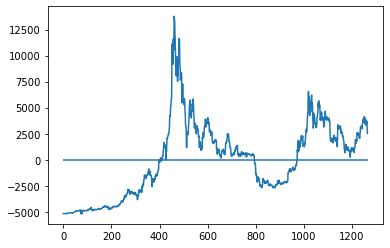

In [15]:
def strategy():
    price_A = df1.values[:len(df2)]
    price_B = df2.values[:len(df2)]
    spread = price_A - price_B
    mspread = spread - np.mean(spread)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(mspread)), mspread)
    ax.hlines(0, 0, len(mspread))
    plt.show()
strategy()

- 设置开仓和止损的阈值
- 为了使开仓和止损的阈值更好地比较，所以就将开仓阈值设置为窗口内数据的两倍标准差，止损设置为三倍标准差。这个标准差的倍数可以通过调参来不断调优，标准差的设置也可以通过 GARCH 等模型拟合的自回归条件异方差类似的时变标准差来代替。

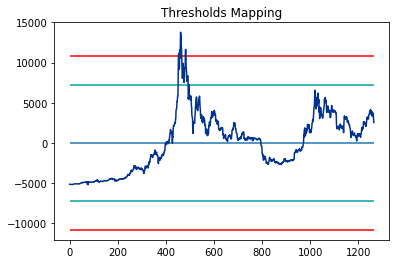

In [56]:
price_A = df1.values[:len(df2)]
price_B = df2.values[:len(df2)]
def strategy():
    spread = price_A - price_B
    mspread = spread - np.mean(spread)
    sigma = np.std(mspread)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(mspread)), mspread,color='#00338D')
    ax.hlines(0, 0, len(mspread))
    ax.hlines(2 * sigma, 0, len(mspread), colors='#00A3A3')
    ax.hlines(-2 * sigma, 0, len(mspread), colors='#00A3A3')
    ax.hlines(3 * sigma, 0, len(mspread), colors='r')
    ax.hlines(-3 * sigma, 0, len(mspread), colors='r')
    plt.title("Thresholds Mapping")
    plt.savefig('thre.png')
    plt.show()
strategy()

In [59]:
def strategy():
    spread = price_A - price_B
    mspread = spread - np.mean(spread)
    sigma = np.std(mspread)
    open = 2 * sigma
    stop = 3 * sigma
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 1000
    agold = 0.005
    abitcoin = 0.030
    for i in range(len(price_A)):
        if hold == False:
            if mspread[i] >= open:
                hold_price_A = price_A[i]
                hold_price_B = price_B[i]
                hold_state = -1
                hold = True
            elif mspread[i] <= -open:
                hold_price_A = price_A[i]
                hold_price_B = price_B[i]
                hold_state = 1
                hold = True
        else:
            if mspread[i] >= stop and hold_state == -1 :
                profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                profit_sum += profit
                hold_state = 0
                hold = False
            if mspread[i] <= -stop and hold_state == 1 :
                profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B*(1-agold) - price_B[i])
                profit_sum += profit
                hold_state = 0
                hold = False
            if mspread[i] <= 0 and hold_state == -1:
                profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                profit_sum += profit
                hold_state = 0
                hold = False
            if mspread[i] >= 0 and hold_state == 1:
                profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B *(1-agold)- price_B[i])
                profit_sum += profit
                hold_state = 0
                hold = False
        profit_list.append(profit_sum)
    print(profit_list)
 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(profit_list)), profit_list,color ='#005FB8')
    plt.title('Pairs Trading Model Version 1.0')
    plt.savefig('1.0.png')
    plt.show()

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 100

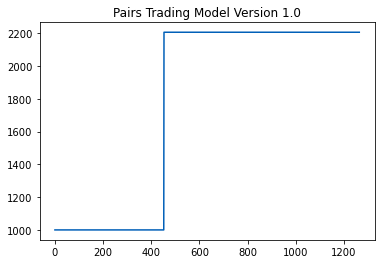

In [60]:
strategy()

In [165]:
def strategy():
    price_A = df1.values[:len(df2)]
    price_B = df2.values[:len(df2)]
    spread = price_A - price_B
    mspread = spread - np.mean(spread)
    sigma = np.std(mspread)
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 1000
    # agold =0.01
    # abitcoin = 0.02
    z_entry_threshold=0.5
    z_exit_threshold1=3
    zscore = mspread/sigma
    a = pd.DataFrame()
    gli=[]
    bli=[]
    for agold in np.arange(0.01,0.8,0.05):
        for abitcoin in np.arange(0.01,0.8,0.05):
            for i in range(len(price_A)):
                if hold == False:
                    if  zscore[i] >= z_entry_threshold:
                        hold_price_A = price_A[i]
                        hold_price_B = price_B[i]
                        hold_state = -1
                        hold = True
                    elif zscore[i] <= -z_entry_threshold:
                        hold_price_A = price_A[i]
                        hold_price_B = price_B[i]
                        hold_state = 1
                        hold = True
                else:
                    if zscore[i] >= z_exit_threshold1 and hold_state == -1 :
                        profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                        profit_sum += profit
                        hold_state = 0
                        hold = False
                    if zscore[i] <= -z_exit_threshold1 and hold_state == 1 :
                        profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B*(1-agold) - price_B[i])
                        profit_sum += profit
                        hold_state = 0
                        hold = False
                    if zscore[i] <= 0 and hold_state == -1:
                        profit = (hold_price_A*(1-abitcoin) - price_A[i]) + (price_B[i] - hold_price_B*(1-agold))
                        profit_sum += profit
                        hold_state = 0
                        hold = False
                    if zscore[i] >= 0 and hold_state == 1:
                        profit = (price_A[i] - hold_price_A*(1-abitcoin)) + (hold_price_B *(1-agold)- price_B[i])
                        profit_sum += profit
                        hold_state = 0
                        hold = False
                profit_list.append(np.array(profit_sum).item())
                
    # d = pd.DataFrame(np.array([agold],abitcoin,profit_list]),columns=['a', 'b', 'c'])
    d = {'col3':profit_list}
        # d.append(
    d = pd.DataFrame(d)
    return d
           

    #         x = pd.DataFrame(x)
    #         a.append(x,ignore_index=True)
    # a
                     

            # fig = plt.figure()
            # ax = fig.add_subplot(111)
            # ax.plot(range(len(profit_list)), profit_list,color ='#005FB8')
            # plt.title('Pairs Trading Model Version 2.0')
            # # plt.savefig('1.0.png')
            # plt.show()
d = strategy()

In [166]:
d.to_csv('sense.csv')

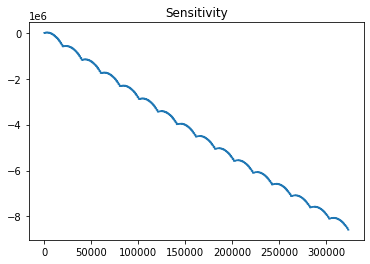

In [169]:
d['col3'].plot()
plt.title('Sensitivity')
plt.savefig('sems.png')

<AxesSubplot:>

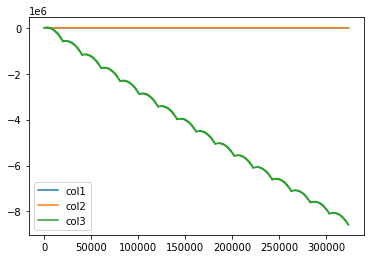

In [160]:
d.plot()

In [162]:
d

,col1,col2,col3
0,0.76,0.76,1.000000e+03
1,0.76,0.76,1.000000e+03
2,0.76,0.76,1.000000e+03
3,0.76,0.76,1.000000e+03
4,0.76,0.76,1.000000e+03
...,...,...,...
323835,0.76,0.76,-8.583085e+06
323836,0.76,0.76,-8.583085e+06
323837,0.76,0.76,-8.583085e+06
323838,0.76,0.76,-8.583085e+06
